In [1]:
%%time

import numpy as np
from numpy import percentile
import pandas as pd
import os
import copy
import time

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
np.random.seed(22)

import tensorflow as tf
#tf.debugging.set_log_device_placement(True)


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import pydot
from IPython.display import display_png

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
!git clone https://github.com/QCDHUB/SIDIS-Affinity

%cd '/content/SIDIS-Affinity'

# google hosted test data
collinear_feild = '1M2MprjFCMT0DfqX7kV_dF591YZGJAhBl' # collinear
current_feild = '1WwNcRixgruw784SCLf9iP4rM0p6V3HhM'   # current
target_feild = '1nrd9cLrDUK4w_4upGvWz2qe5l7hrNXqR'    # target
tmd_feild = '1Iz1REawJ7W8s3xmAG-dykeg0isPLR8UA'       # tmd
soft_feild = '1t2lxR5XWMcH-bvtqvNt2rVdQvQwolbPG'      # soft

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$collinear_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$collinear_feild" -O collinear && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$current_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$current_feild" -O current && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$target_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$target_feild" -O target && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$tmd_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$tmd_feild" -O TMD && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$soft_feild' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$soft_feild" -O soft && rm -rf /tmp/cookies.txt


2.7.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 223638224888273938
xla_global_id: -1
]
Cloning into 'SIDIS-Affinity'...
remote: Enumerating objects: 4370, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4370 (delta 8), reused 0 (delta 0), pack-reused 4352
Receiving objects: 100% (4370/4370), 2.18 GiB | 14.27 MiB/s, done.
Resolving deltas: 100% (1875/1875), done.
Checking out files: 100% (2792/2792), done.
/content/SIDIS-Affinity
--2022-01-16 14:27:21--  https://docs.google.com/uc?export=download&confirm=&id=1M2MprjFCMT0DfqX7kV_dF591YZGJAhBl
Resolving docs.google.com (docs.google.com)... 74.125.31.100, 74.125.31.138, 74.125.31.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.31.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-18-docs.googleusercontent.com/docs/securesc/bro0slf1e30k3ggg3qr07jurjtmj

In [2]:
# setting up latex
!apt-get update
import matplotlib
from matplotlib import rc
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

In [9]:
# Define plotting functions


def plotPred(trueVal,predVal,title,threshold):
    ## set font
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

    ## create figure and axis
    fig = plt.figure(figsize=(10,10))
    a = plt.axes(aspect='equal')
    a.tick_params(axis='both', which='both', labelsize=30, direction='in', length=12)
    # a.set_facecolor('lightgray') 
    
    ## plot points
    plt.scatter(trueVal, predVal,c='aqua',alpha=0.07)
    plt.yticks([0.2,0.4,0.6,0.8,1.0])
    
    ## set up lables and titile
    plt.xlabel('Generated Affinity',fontsize=35, labelpad=20)
    plt.ylabel('Predicted Affinity',fontsize=35)
    plt.title(title,fontsize=35, position=(0.3, 0.9))
    # a.set_title(title, y=1.0, pad=-14,fontsize=35)
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    
    ## adding line of zero residuals    
    plt.plot(lims, lims ,color = 'k',linestyle='-',linewidth=2.5)

    ## add lines for residual threshold containing center 95%
    x1 = np.linspace(0,1-threshold,100)
    plt.plot(x1,x1+threshold, color = 'red',linestyle='--',linewidth=2.5)
    x2 = np.linspace(threshold,1,100)
    plt.plot(x2,x2-threshold, color = 'red',linestyle='--',linewidth=2.5)
    plt.show()

    ## save plot as pdf
    # from matplotlib.backends.backend_pdf import PdfPages
    # with PdfPages('../%s.pdf' % title) as pdf:
    #     pdf.savefig(fig)

    ## save plot as .png
    plt.savefig('../%s.png' % title)


def getThresh(residuals):
    print('Using bisection search algorithm to find |threshold| contains 95% of residuals')
    badRes = np.ones(len(residuals)).tolist()
    lowThresh = 0.0000000001
    upperThresh = 1.
    threshold = lowThresh
    tolerance = 0.000001
    atol = len(badRes)/len(residuals)
    iterCount = 0

    while np.abs(atol - .05) > tolerance :

        badRes = [res for res in residuals if np.abs(res) > threshold]
        atol = len(badRes)/len(residuals)

        if np.abs(atol - 0.05) < tolerance: 
            break

        else:
            if atol < 0.05:
                upperThresh = threshold
            else:
                lowThresh = threshold
                
        threshold = (upperThresh + lowThresh)/2 
        iterCount += 1

    print('# residuals: ',len(residuals))
    print('# residuals outside threshold: ',len(badRes))
    print('percent residuals outside threshold: ',len(badRes)/len(residuals))
    print('max |residual|: ', max(np.abs(residuals)))
    print('min |residual|: ', min(np.abs(residuals)))
    print('threshold: ', threshold)
    print('# of iterations: ',iterCount)
    print('#'*12,'\n'*2)
    print('Percent residuals within +/- %s' % threshold)
    accuracy = len([res for res in residuals if np.abs(res) <= threshold])/len(residuals)
    print('accuracy: ',accuracy)
    print('Percent residuals == 0.0')
    accuracy = len([res for res in residuals if np.abs(res) == 0.0])/len(residuals)
    print('accuracy: ',accuracy)
    return(threshold)


def getThresh2(residuals):
    print('Using percentiles to define center 95% of residuals')
    threshold = percentile(residuals, [2.5, 97.5])
    print('Percent residuals within %s' % threshold)
    accuracy = np.mean((residuals > threshold[0]) & (residuals < threshold[1]))
    print('accuracy: ',accuracy)
    print('Percent residuals == 0.0')
    accuracy = np.mean(residuals == 0.0)
    print('accuracy: ',accuracy)
    return(threshold)


def fivenumsum(resids):
    # calculate a 5-number summary
    from numpy import percentile
    quartiles = percentile(resids, [0, 25, 50, 75, 100])
    # print 5-number summary
    print('Min: %.3f' % quartiles[0])
    print('Q1: %.3f' % quartiles[1])
    print('Median: %.3f' % quartiles[2])
    print('Q3: %.3f' % quartiles[3])
    print('Max: %.3f' % quartiles[4])
    
def scot_plot(mld_path, file_path, lable_name, title):
    
    test_results = {}
    model = tf.keras.models.load_model(mld_path)
    # test_features = np.load(file_path,allow_pickle=True)
    test_features = pd.read_csv(file_path)
    # test_features = test_features.sample(7400) # down sample to size of 1 data-set
    
    # test_features = np.array(test_features, np.float)
    # test_features = test_features.drop(columns=['currentaff','targetaff', 'collinearaff','hadron'])
    # print(test_features.head())
    test_labels = test_features.pop(lable_name)
    print('Model Configureation')
    print('#'*12,'\n'*2)
    for i, layer in enumerate (model.layers):
        print ('layer', i, layer)
        try:
            print ("    ", layer.activation)
        except AttributeError:
            print('   no activation attribute')
        
    print('#'*12,'\n'*2)
    print('Model Summary')
    print(model.summary())
    test_results[model_name] = model.evaluate(test_features, test_labels, verbose=0)
    test_predictions = model.predict(test_features).flatten()
    print('#'*12,'\n'*2)

    ## if the NN prediction are not bounded between [0,1]
    # negPred=[value for value in test_predictions if value < 0]
    # giantPred=[value for value in test_predictions if value > 1]
    # print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

    # if len(negPred)==0 and len(giantPred)==0:
    #     print('no correction needed')
    # else:
    #     print('setting negative predictions to 0\nsetting predictions > 1 to 1')
    #     test_predictions[test_predictions<0] = 0
    #     test_predictions[test_predictions>1] = 1
    #     print('testing affinity correction...')
    #     negPred=[value for value in test_predictions if value < 0]
    #     giantPred=[value for value in test_predictions if value > 1]
    #     print('# of predictions < 0:',len(negPred),'\n# of predictions > 1:',len(giantPred))

    # badRes = [res for res in list(residuals) if np.abs(res) >= threshold] # residuals that are above threshold
    # #print(badRes)
    # percentBadRes = len(badRes)/len(residuals)
    # print('#'*12,'\n'*2)

    residuals = test_labels-test_predictions
    threshold = getThresh(residuals)
    print('#'*12,'\n'*2)
    _ = getThresh2(residuals)



    # Calculate R squared
    print('----------------------------')
    print('\nModel Stats')
    R2 = r2_score(test_labels, test_predictions, multioutput='variance_weighted')
    print('mse: ',test_results[model_name])
    print('R-squared: ',R2)
    # print(np.round(percentBadRes,6),'percent of residuals were above threshold 0.2 for',len(test_labels),' predictions')
    # print(len(badRes),' residuals were above threshold 0.2 for',len(test_labels),' predictions')
    # print('max |residual|: ',max(np.abs(residuals)))
    print('#'*12,'\n'*2)
    print('Five number summary of residuals')
    fivenumsum(residuals)
    print('#'*12,'\n'*2)
    plotPred(test_labels,test_predictions,title,threshold)
    plt.figure(figsize=(10,10))
    print('\n')
    plt.hist(residuals,bins=100)
    plt.show()
    print('#'*12,'\n'*2)
    
    # adding network plots
    print('----------------------------')
    print('\nNetwork Plots')
    print('tracing network dimentions.')
    display_png(tf.keras.utils.model_to_dot(model,
                    show_shapes=True, show_dtype=False, show_layer_names=False, 
                    show_layer_activations=False, rankdir="LR", dpi=96
                ).create(prog='dot', format='png'),raw=True)
    print('tracing activation functions')
    display_png(tf.keras.utils.model_to_dot(model,
                    show_shapes=False, show_dtype=False, show_layer_names=False, 
                    show_layer_activations=True, rankdir="LR", dpi=96
                ).create(prog='dot', format='png'),raw=True)


# TMD 

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f1e03a5c4d0>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f1e03a5cd90>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f1e03a64250>
     <function relu at 0x7f1e127158c0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f1e03a3b1d0>
     <function relu at 0x7f1e127158c0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f1e03a3bc10>
     <function sigmoid at 0x7f1e12715dd0>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

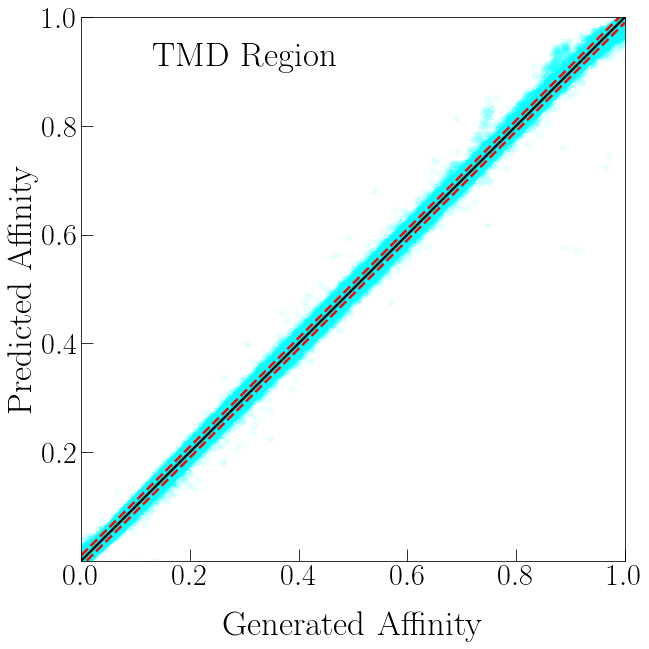

<Figure size 432x288 with 0 Axes>

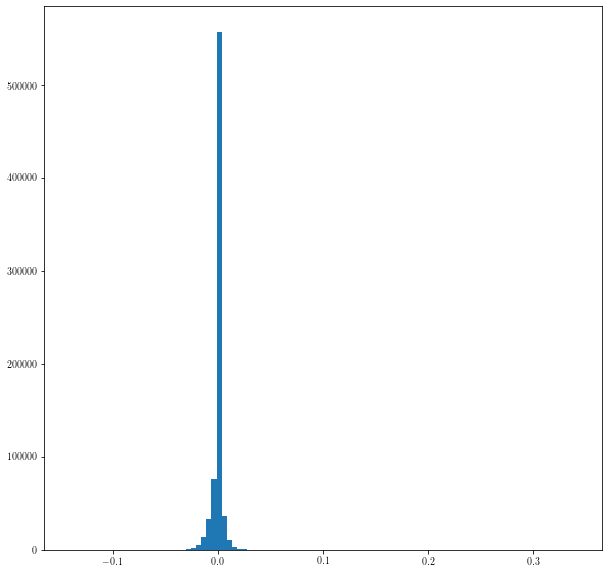

############ 


----------------------------

Network Plots
tracing network dimentions.


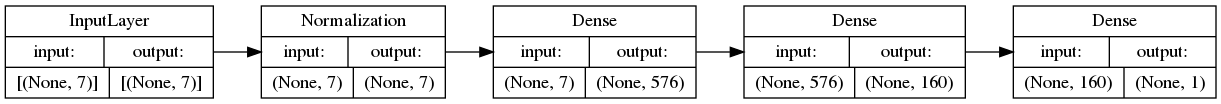

tracing activation functions


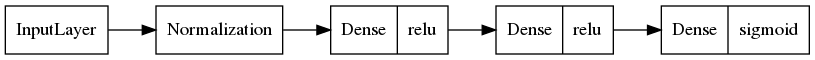

CPU times: user 1min 24s, sys: 4.87 s, total: 1min 29s
Wall time: 1min 31s


In [10]:
%%time

# region_name = 'collinear'
# region_name = 'target'
# region_name = 'current'
region_name = 'TMD'
lable_name = 'tmdaff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'TMD Region'

scot_plot(mld_path, file_path, lable_name, title)

# Current

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f1e0903ed50>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f1e0d5dec90>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f1e0d80ba90>
     <function relu at 0x7f1e127158c0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f1e0cf1b090>
     <function relu at 0x7f1e127158c0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f1e0d991d10>
     <function sigmoid at 0x7f1e12715dd0>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

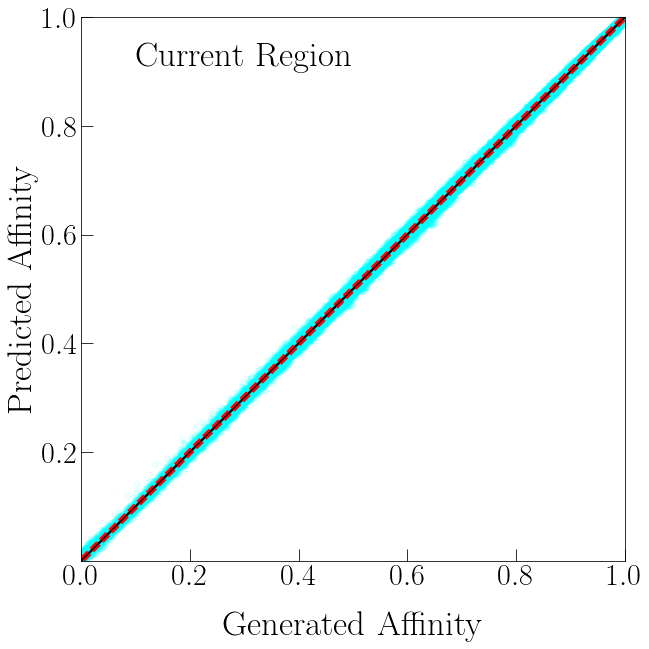

<Figure size 432x288 with 0 Axes>

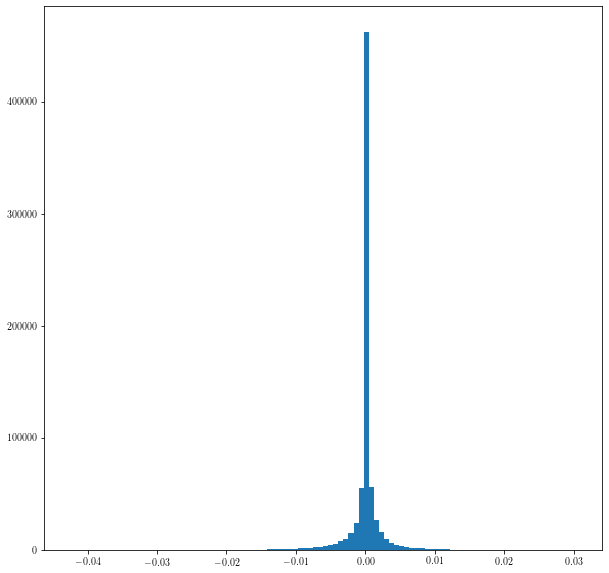

############ 


----------------------------

Network Plots
tracing network dimentions.


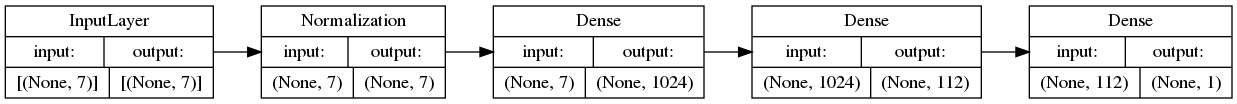

tracing activation functions


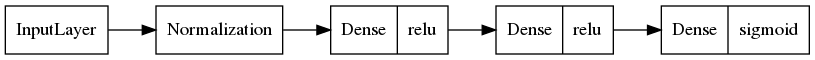

CPU times: user 1min 34s, sys: 6.09 s, total: 1min 40s
Wall time: 1min 33s


In [11]:
%%time

# region_name = 'collinear'
# region_name = 'target'
region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Current Region'

scot_plot(mld_path, file_path, lable_name, title)

# Collinear

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f1e0906f9d0>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f1e0904c310>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f1e090471d0>
     <function relu at 0x7f1e127158c0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f1e0dabe390>
     <function relu at 0x7f1e127158c0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f1e09052050>
     <function sigmoid at 0x7f1e12715dd0>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

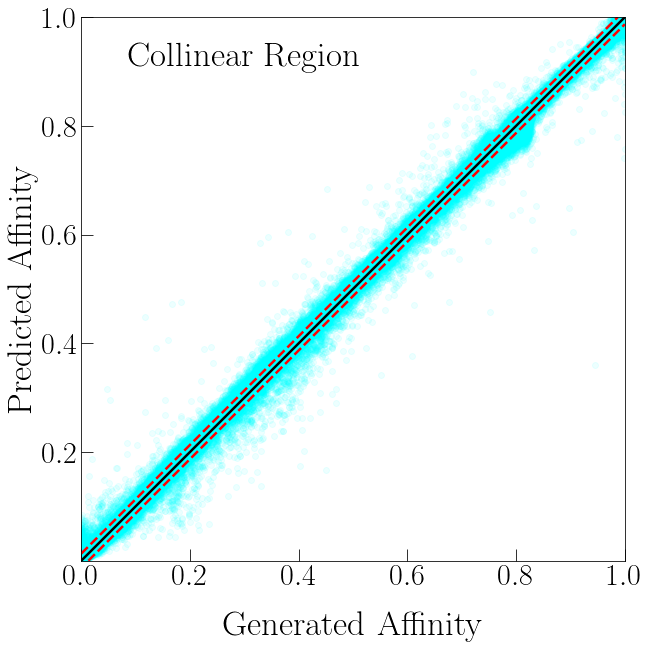

<Figure size 432x288 with 0 Axes>

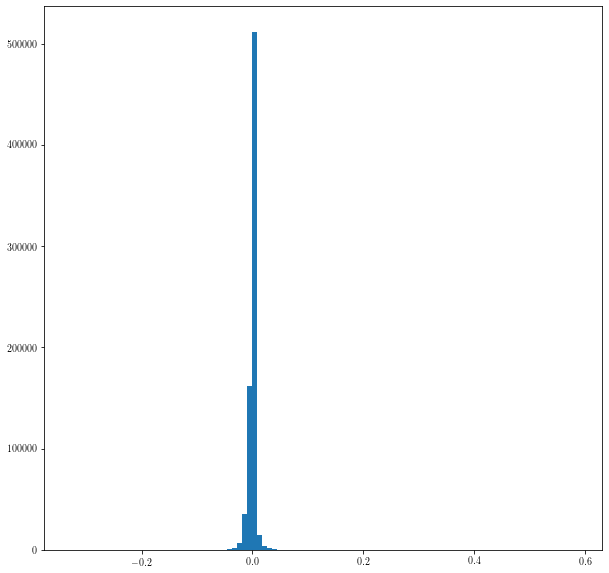

############ 


----------------------------

Network Plots
tracing network dimentions.


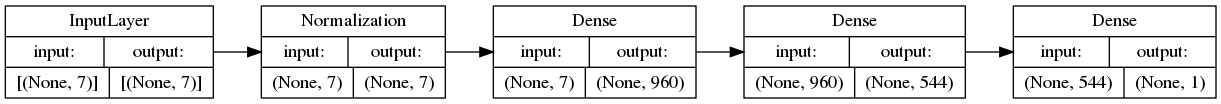

tracing activation functions


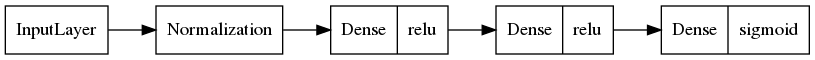

CPU times: user 2min 52s, sys: 8.77 s, total: 3min
Wall time: 2min 49s


In [12]:
%%time

region_name = 'collinear'
# region_name = 'target'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Collinear Region'

scot_plot(mld_path, file_path, lable_name, title)

# target

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f1e0d9f3d90>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f1e0904c350>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f1e0d5cf050>
     <function relu at 0x7f1e127158c0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f1e08e45290>
     <function relu at 0x7f1e127158c0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f1e0d309110>
     <function sigmoid at 0x7f1e12715dd0>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

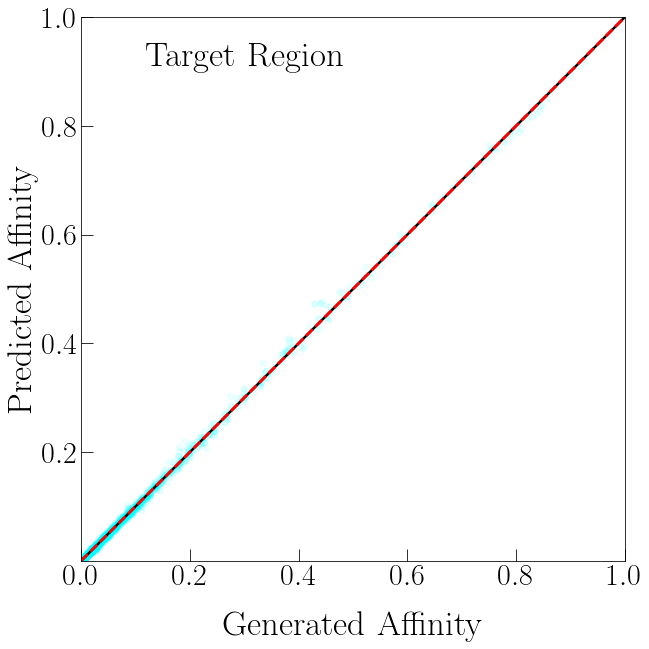

<Figure size 432x288 with 0 Axes>

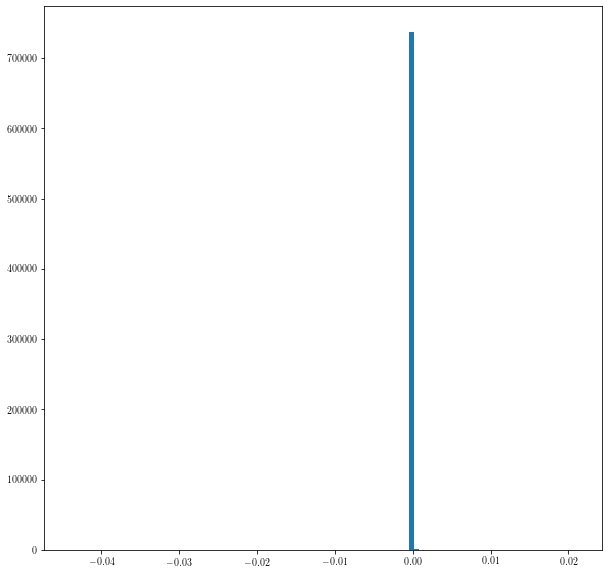

############ 


----------------------------

Network Plots
tracing network dimentions.


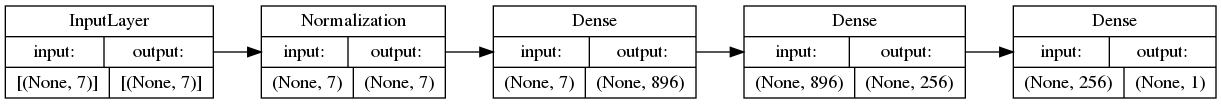

tracing activation functions


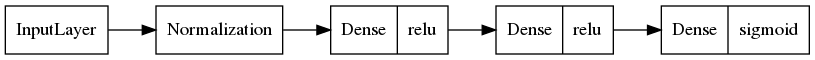

CPU times: user 2min, sys: 6.35 s, total: 2min 6s
Wall time: 2min


In [13]:
%%time

# region_name = 'collinear'
region_name = 'target'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Target Region'

scot_plot(mld_path, file_path, lable_name, title)

# soft

Model Configureation
############ 


layer 0 <keras.engine.input_layer.InputLayer object at 0x7f1e0904ca50>
   no activation attribute
layer 1 <keras.layers.preprocessing.normalization.Normalization object at 0x7f1e0d32a690>
   no activation attribute
layer 2 <keras.layers.core.dense.Dense object at 0x7f1e03904a90>
     <function relu at 0x7f1e127158c0>
layer 3 <keras.layers.core.dense.Dense object at 0x7f1e038eebd0>
     <function relu at 0x7f1e127158c0>
layer 4 <keras.layers.core.dense.Dense object at 0x7f1e04fcf450>
     <function sigmoid at 0x7f1e12715dd0>
############ 


Model Summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                       

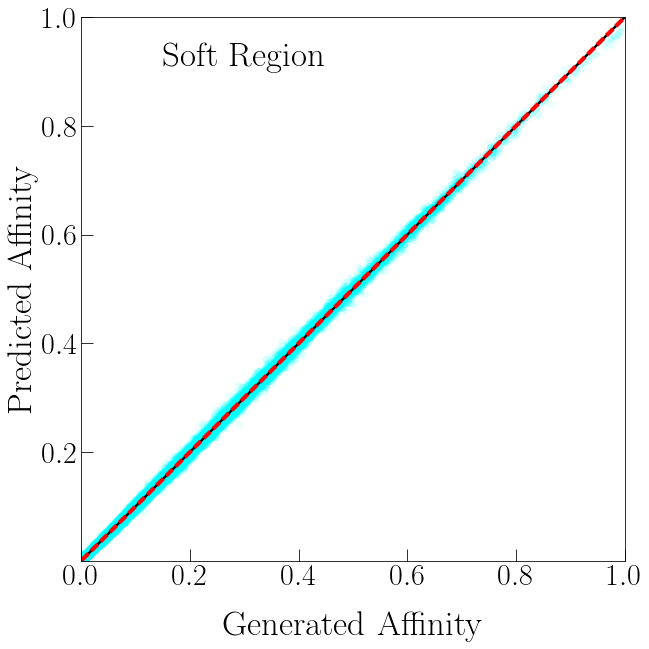

<Figure size 432x288 with 0 Axes>

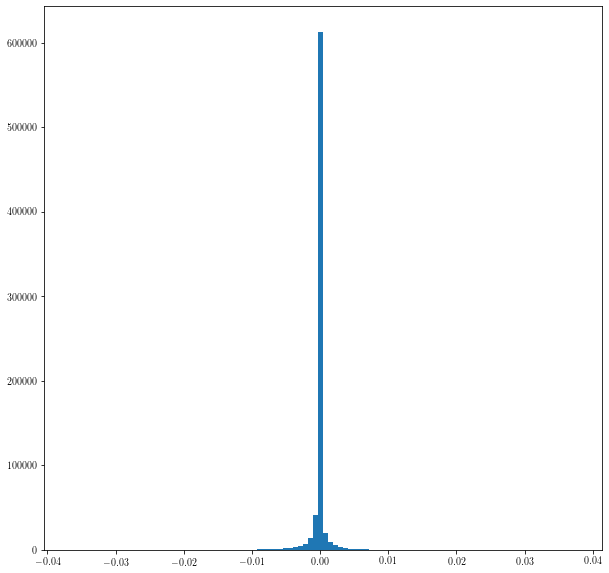

############ 


----------------------------

Network Plots
tracing network dimentions.


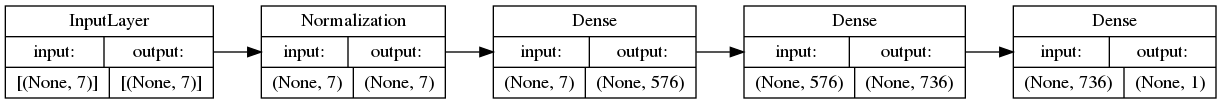

tracing activation functions


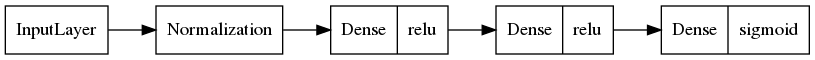

CPU times: user 2min 37s, sys: 9.1 s, total: 2min 46s
Wall time: 3min 10s


In [14]:
%%time

# region_name = 'collinear'
region_name = 'soft'
# region_name = 'current'
# region_name = 'TMD'
lable_name = region_name + 'aff'
file_name = region_name
file_path = './' + file_name
model_name = 'final_' + region_name
mld_path = './models/' + model_name
title = 'Soft Region'

scot_plot(mld_path, file_path, lable_name, title)